# 1. Optimal Growth

Problem: 
- $V(k) = \max_{c,k'} \left\{ log(c)+βV(k') \right\}$
- $c+k'= f(k) = k^\alpha + (1-\delta)k$
- $c, k' \in [0, f(k)]$

Solution: 
- Euler: $c^{-1}=\beta*c'^{-1}(\alpha k'^{\alpha-1} + 1-\delta)$
- Find $k_{ss}$ from $1=\beta*(\alpha k_{ss}^{\alpha-1} + 1-\delta)$ 
- Guess $V_0(k)=log(k)$ in $[k_{ss}*0.9, k_{ss}*1.1]$
- Iterate $V_{t+1}(k) = \max_{0 \leq k' \leq f(k)} \left\{log(f(k) - k')+ βV_{t}(k')\right\}$ until convergence
- Store policy rules $k'(k)$ and $c(k) = f(k) - k'(k)$
- From initial $k_{0}$ simulate economy with $k_{t+1}=k'(k_{t})$ and $c_{t}=c(k_{t})$

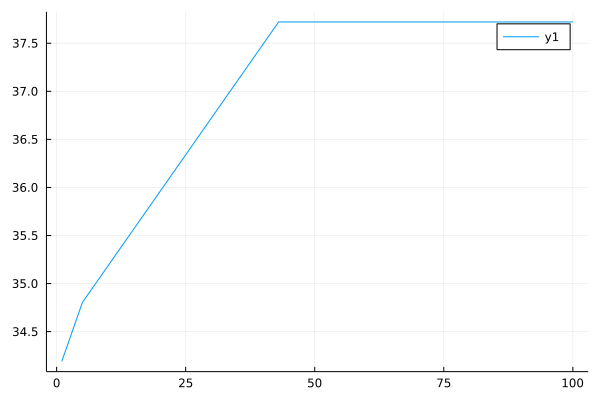

In [1]:
using LinearAlgebra, Plots

# Param
α = 0.36
δ = 0.025
β = 0.99

# Steady State
Kss = ((1/β+δ-1)/α)^(1/(α-1))
#print(Kss)

# Grids
K = Array(range(Kss*0.9,Kss*1.1,100))
V_ = log.(K)
V = log.(K)
KP = β*K;

# VFI
error = 1
while error>1e-10
    for (i,k) in enumerate(K)
        y = k^α+(1-δ)*k
        mask = ifelse.(K.<=y, 1.0, NaN)
        RHS = log.(y.-K.*mask)+β*V_.*mask
        RHS[isnan.(RHS)] .= -Inf
        v, kpi = findmax(RHS)
        KP[i] = K[kpi[1]]
        V[i] = v[1]
    end
    error = norm(V-V_)
    V_ = copy(V)
end
display(plot(K,V))
display(plot(K,KP))
        
# Simulate
k0 = Kss*0.9
T = 100
PATH = k0*Array(1:T)
for i in 1:T-1
    PATH[i+1] = KP[partialsortperm(abs.(K .- PATH[i]), 1)]
end
display(plot(PATH))

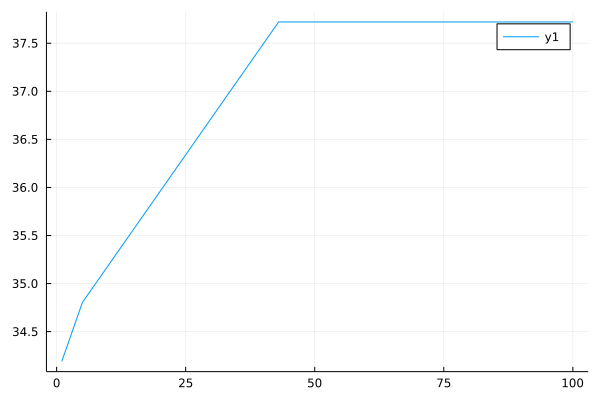

nothing

In [9]:
using Plots
print(display(plot(PATH)))

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1145dbd00>

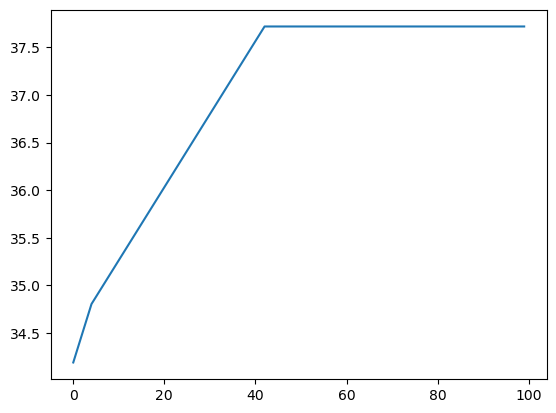

In [4]:
display(plot(PATH))

# 2. Stochastic Optimal Growth

Problem: 
- $V(k,z) = \max_{c,k'} \{log(c)+βE[V(k',z')|z]\}$
- $c+k'= f(k,z) = zk^\alpha + (1-\delta)k$
- $c, k' \in [0, f(k,z)]$
- $E[V(k', z')|z] = \sum_{z'} P_{zz'} V(k',z')$
- $P$ is known transition matrix, $Z$ is discrete shock space, $E[z]=1$

Solution: 
- Euler: $c^{-1}=\beta*E[c'^{-1}(z' \alpha k'^{\alpha-1} + 1-\delta)|z]$
- Find $k_{ss}$ from $1=\beta*(\alpha k_{ss}^{\alpha-1} + 1-\delta)$ 
- Guess $V_0(k,z)= log(k)$ in $[k_{ss}*0.9, k_{ss}*1.1]$ x $Z$
- Iterate $V_{t+1}(k,z) = \max_{0 \leq k' \leq f(k)} \left\{log(f(k) - k')+ E[βV_{t}(k',z')|z]\right\}$ until convergence
- Store policy rules $k'(k,z)$ and $c(k,z) = f(k,z) - k'(k,z)$
- From initial $k_{0},z_{0}$ simulate economy with $k_{t+1}=k'(k_{t},z_{t})$ and $c_{t}=c(k_{t},z_{t})$

In [177]:
using Plots, LinearAlgebra

# Params
α = 0.36
δ = 0.025
β = 0.99
σ = 2.0
f(z,k) = z*(k^α)
u(c) = (c^(1-σ))/(1-σ)
Kss = ((1/β+δ-1)/α)^(1/(α-1))

# Grids
K= Array(range(Kss*0.9,Kss*1.1,200))
Z = [0.99 1.01]
P = Array([0.9 0.1; 0.1 0.9])
V_ = u.(K.*Z)
V = u.(K.*Z)
KP = β*(K.*Z);
CP = β*(K.*Z);

# VFI
error = 1
while error>1e-6
    for (ki,k) in enumerate(K)
        for (zi,z) in enumerate(Z)
            y = f(z,k)+(1-δ)*k
            mask = ifelse.(K.<=y, 1.0, NaN)
            RHS = log.(y.-K.*mask)+β*(V_[:, 1]*P[zi,1].+V_[:, 2].*P[zi,2]).*mask
            RHS[isnan.(RHS)] .= -Inf
            v, kpi = findmax(RHS)
            KP[ki,zi] = K[kpi[1]]
            V[ki, zi] = v[1]
            CP[ki, zi] = y-KP[ki,zi];
        end
    end
    error = norm(V-V_)
    V_ = copy(V)
end

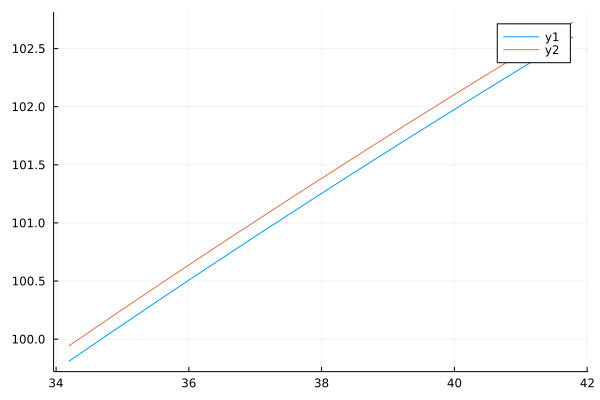

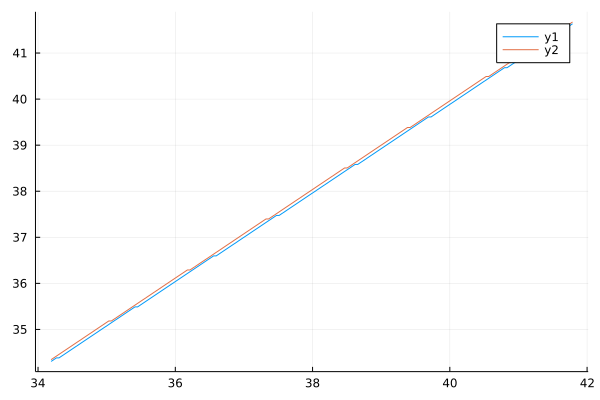

In [178]:
display(plot(K,V))
display(plot(K,KP))

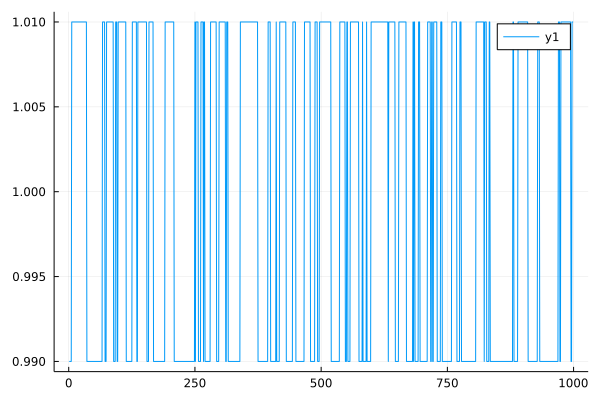

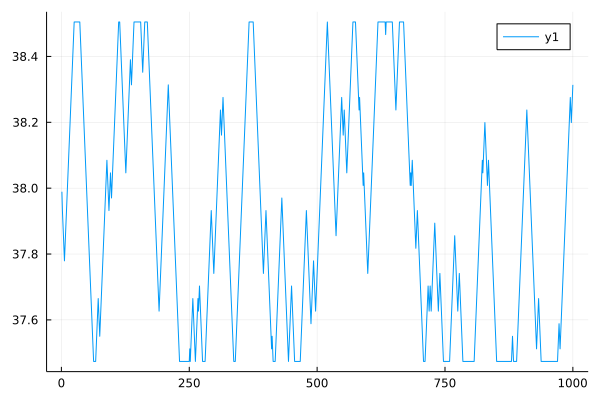

In [179]:
# Simulate
using QuantEcon
k0 = Kss
z0 = Z[1]
T = 1000
ZIND = simulate(MarkovChain(P), T);
KIND = simulate(MarkovChain(P), T);
KPATH = k0*Array(1:T)
ZPATH = z0*Array(1:T-1);

for i in 1:T-1
    z = ZIND[i]
    KIND[i] = partialsortperm(abs.(K .- KPATH[i]), 1)
    KPATH[i+1] = KP[KIND[i], z]
    ZPATH[i] = Z[z]
    #println((z, KPATH[i], KPATH[i+1], ZPATH[i]))
end
display(plot(ZPATH))
display(plot(KPATH))

# 3.  Optimal Growth (Coleman Operator)

Problem: 
- $V(k) = \max_{c,k'} \left\{ log(c)+βV(k') \right\}$
- $c+k'= f(k) = k^\alpha$ (full depreciation)
- $c, k' \in [0, y]$

Solution: 
- Euler: $c^{-1}=\beta*c'^{-1}\alpha k'^{\alpha-1}$
- Find $k_{ss}$ from $1=\beta*\alpha k_{ss}^{\alpha-1}$ 
- Guess $c_{t}(k)=\alpha k$ in $[k_{ss}*0.9, k_{ss}*1.1]$
- For each k, update $c_{t+1}(k)$ with $c$ that solves: $c^{-1}-\beta c_{t}(k^\alpha-c)^{-1} f'(k^\alpha-c)=0$ until convergence
- Store policy rules $c(k)$ and $k'(k) = f(k) - c(k)$
- From initial $k_{0}$ simulate economy with $k_{t+1}=k'(k_{t})$ and $c_{t}=c(k_{t})$

In [4]:
using LinearAlgebra, Statistics
using BenchmarkTools, Interpolations, LaTeXStrings, Parameters, Plots, QuantEcon, Roots
using Optim, Random
using BenchmarkTools, Interpolations, Parameters, Plots, QuantEcon, Roots

In [5]:
function coleman!(Kg, g, K, β, up, f, fp)
    g_func = LinearInterpolation(K, g, extrapolation_bc = Line())
    for (i,k) in enumerate(K)
        #println(" ", (i,y))
        function h(c)
            kp = f(k) - c
            vals = up.(g_func.(kp)) .* fp(kp)
            return up(c) - β * mean(vals)
        end
        Kg[i] = find_zero(h, (1e-10, f(k)-1e-10))
    end
    return Kg
end

coleman(g, K, β, up, f, fp) = coleman!(similar(g), g, K, β, up, f, fp)

coleman (generic function with 1 method)

0.2522434462207315


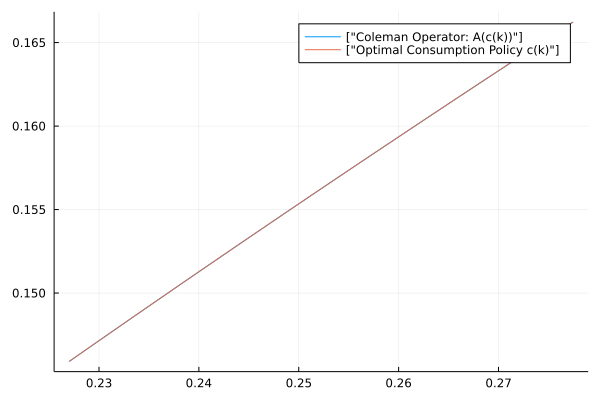

In [7]:
σ = 1.0
β = 0.95
α = 0.65
up(c) = c^(-σ)
f(k) = k^α
fp(k) = α*k^(α-1)
Kss = (1/(α*β))^(1/(α-1))
println(Kss)
K = Array(range(Kss*0.9, Kss*1.1, 200))
    
# Check Coleman Operator
cstar = (1-α*β).*f.(K) # True Policy
plot(K,cstar, label=["Coleman Operator: A(c(k))"])
plot!(K,coleman(cstar, K, β, up, f, fp), label=["Optimal Consumption Policy c(k)"])

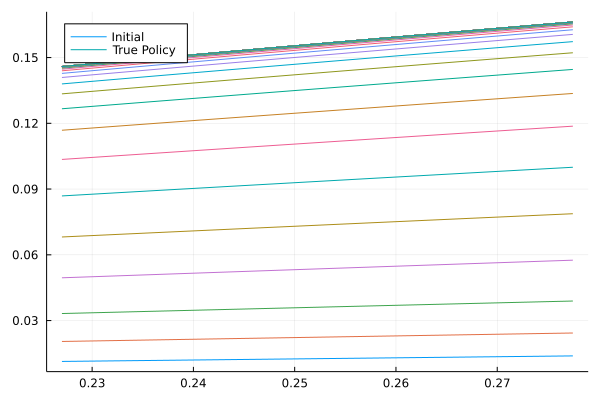

In [8]:
function timeIteration(cstar, c_init)
    c = c_init
    plot(K,c,label = "Initial")
    for t in 1:100
        new_c = coleman(c, K, β, up, f, fp)
        c = new_c
        plot!(K, c, label=false)
    end
    plot!(K,cstar, label="True Policy")
    display(plot!(legend=:topleft))
    return c
end

c_init = (1-β)*K
cpolicy = timeIteration(cstar, c_init)
kpolicy = f.(K) - cpolicy;

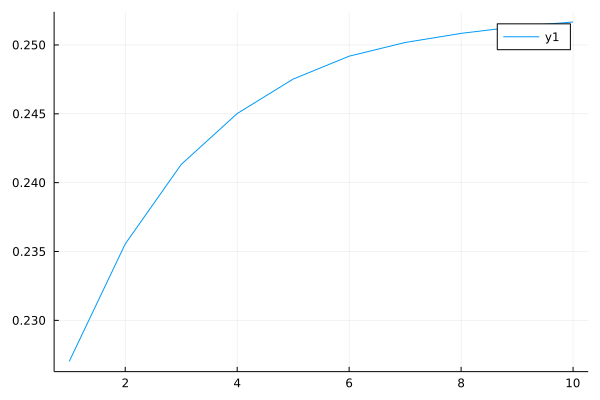

In [9]:
# Simulate
k0 = Kss*0.9
T = 10
PATH = k0*Array(1:T)
for i in 1:T-1
    PATH[i+1] = kpolicy[partialsortperm(abs.(K .- PATH[i]), 1)]
end
display(plot(PATH))

# 4. Stochastic Optimal Growth (Coleman Operator)

Problem: 
- $V(k,z) = \max_{c,k'} \{log(c)+βE[V(k',z')|z]\}$
- $c+k'= f(k,z) = zk^\alpha $
- $c, k' \in [0, f(k,z)]$
- $E[V(k', z')|z] = \sum_{z'} P_{zz'} V(k',z')$
- $P$ is known transition matrix, $Z$ is discrete shock space, $E[z]=1$

Solution: 
- Euler: $c^{-1}=\beta*E[c'^{-1}(z' \alpha k'^{\alpha-1})|z]$
- Find $k_{ss}$ from $1=\beta*(\alpha k_{ss}^{\alpha-1})$ 
- Guess $c_{t}(k,z)=\alpha k$ in $[k_{ss}*0.9, k_{ss}*1.1]$x$Z$
- For each $k,z$, update $c_{t+1}(k,z)$ with $c$ that solves: $c^{-1}-\beta E[c_{t}(f(k,z)-c,z')^{-1} f_{1}(f(k,z)-c,z')|z]=0$ until convergence
- Store policy rules $c(k,z)$ and $k'(k,z) = f(k,z) - c(k,z)$
- From initial $k_{0},z_{0}$ simulate economy with $k_{t+1}=k'(k_{t},z_{t})$ and $c_{t}=c(k_{t},z_{t})$

In [10]:
using LinearAlgebra, Statistics
using BenchmarkTools, Interpolations, LaTeXStrings, Parameters, Plots, QuantEcon, Roots
using Optim, Random
using BenchmarkTools, Interpolations, Parameters, Plots, QuantEcon, Roots

σ = 1.0
β = 0.95
α = 0.65
up(c) = c^(-σ)
f(k,z) = z*k^α
fp(k,z) = z*α*k^(α-1)
Kss = (1/(α*β))^(1/(α-1))
println(Kss)
K = Array(range(Kss*0.9, Kss*1.1, 200))
Z = [0.99 1.01]
P = Array([0.9 0.1; 0.1 0.9])

function coleman!(Kg1, Kg2, g1, g2, K, β, up, f, fp)
    c1 = LinearInterpolation(K, g1, extrapolation_bc = Line()) # c(k,z1)
    c2 = LinearInterpolation(K, g2, extrapolation_bc = Line()) # c(k,z2)
    for (i,k) in enumerate(K)
        function h1(c) # Euler at k,z1
            kp = f(k,Z[1])-c 
            val1 = up.(c1.(kp)) .* fp(kp,Z[1]) #z'=z[1]
            val2 = up.(c2.(kp)) .* fp(kp,Z[2]) #z'=z[2]
            return up(c) - β*(P[1,1]*val1+P[1,2]*val2)
        end
        function h2(c) # Euler at k,z2
            kp = f(k,Z[2])-c
            val1 = up.(c1.(kp)).* fp(kp,Z[1]) #z'=z[1]
            val2 = up.(c2.(kp)).* fp(kp,Z[2]) #z'=z[2]
            return up(c) - β*(P[2,1]*val1+P[2,2]*val2)
        end
        Kg1[i] = find_zero(h1, (1e-10, f(k,Z[1])-1e-10)) # Update c(k,z1)
        Kg2[i] = find_zero(h2, (1e-10, f(k,Z[2])-1e-10)) # Update c(k,z2)
    end
    return Kg1,Kg2
end
coleman(g1, g2, K, β, up, f, fp) = coleman!(similar(g1), similar(g2), g1, g2, K, β, up, f, fp)

0.2522434462207315


coleman (generic function with 2 methods)

In [11]:
function timeIteration(c1_init, c2_init)
    c1 = c1_init
    c2 = c2_init
    for t in 1:100
        new_c1, new_c2 = coleman(c1, c2, K, β, up, f, fp)
        c1 = new_c1
        c2 = new_c2        
    end
    return c1,c2
end

c1,c2 = timeIteration((1-β).*Z[1].*K, (1-β).*Z[2].*K)
k1 = f.(K,Z[1]) - c1;
k2 = f.(K,Z[2]) - c2;

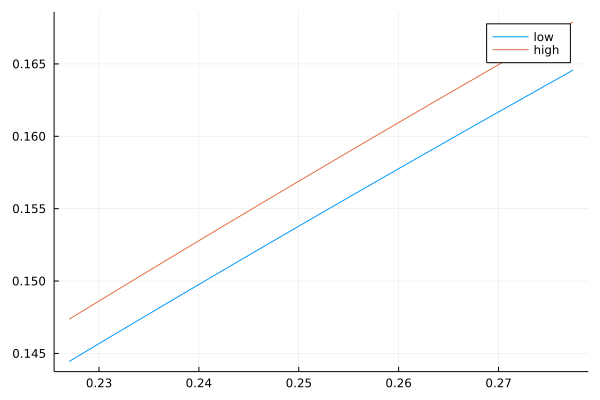

In [12]:
plot(K,c1, label="low")
plot!(K,c2,label="high")

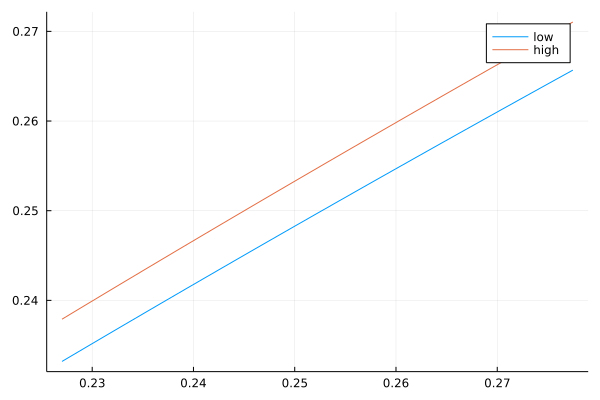

In [13]:
plot(K,k1,label="low")
plot!(K,k2,label="high")

# 5. RBC Warmup Example in GDSGE

Problem: 
- $V(k,z) = \max_{c,k'} \{u(c)+βE[V(k',z')|z]\}$
- u(c) = c^(1-\sigma)/(1-\sigma)
- $c+k'= f(k,z) = zk^\alpha +(1-\delta)k$
- $c, k' \in [0, f(k,z)]$
- $E[V(k', z')|z] = \sum_{z'} P_{zz'} V(k',z')$
- $P$ is known transition matrix, $Z$ is discrete shock space, $E[z]=1$

Solution: 
- Euler: $u'(c)=\beta*E[u'(c')*f'(k')|z]$
- Find $k_{ss}$ from $1=\beta*(\alpha k_{ss}^{\alpha-1}+1-\delta)$ 
- Guess $c_{t}(k,z)$ in $[k_{ss}*0.9, k_{ss}*1.1]$x$Z$
- For each $k,z$, update $c_{t+1}(k,z)$ with $c$ that solves: $u'(c)-\beta E[u'(c_{t}(f(k,z)-c,z')) f_{1}(f(k,z)-c,z')|z]=0$ until convergence
- Store policy rules $c(k,z)$ and $k'(k,z) = f(k,z) - c(k,z)$
- From initial $k_{0},z_{0}$ simulate economy with $k_{t+1}=k'(k_{t},z_{t})$ and $c_{t}=c(k_{t},z_{t})$

In [171]:
using LinearAlgebra, Statistics
using BenchmarkTools, Interpolations, LaTeXStrings, Parameters, Plots, QuantEcon, Roots
using Optim, Random
using BenchmarkTools, Interpolations, Parameters, Plots, QuantEcon, Roots

σ = 2.0
β = 0.99
α = 0.36
δ = 0.025
up(c) = c^(-σ)
f(k,z) = z*k^α+(1-δ)*k
fp(k,z) = z*α*k^(α-1)+(1-δ)
Kss = ((1/β+δ-1)/α)^(1/(α-1))
println(Kss)
K = Array(range(Kss*0.9, Kss*1.1, 200))
Z = [0.99 1.01]
P = Array([0.9 0.1; 0.1 0.9])

function coleman!(Kg1, Kg2, g1, g2, K, β, up, f, fp)
    c1 = LinearInterpolation(K, g1, extrapolation_bc = Line()) # c(k,z1)
    c2 = LinearInterpolation(K, g2, extrapolation_bc = Line()) # c(k,z2)
    for (i,k) in enumerate(K)
        function h1(c) # Euler at k,z1
            kp = f(k,Z[1])-c 
            val1 = up.(c1.(kp)) .* fp(kp,Z[1]) #z'=z[1]
            val2 = up.(c2.(kp)) .* fp(kp,Z[2]) #z'=z[2]
            return up(c) - β*(P[1,1]*val1+P[1,2]*val2)
        end
        function h2(c) # Euler at k,z2
            kp = f(k,Z[2])-c
            val1 = up.(c1.(kp)).* fp(kp,Z[1]) #z'=z[1]
            val2 = up.(c2.(kp)).* fp(kp,Z[2]) #z'=z[2]
            return up(c) - β*(P[2,1]*val1+P[2,2]*val2)
        end
        Kg1[i] = find_zero(h1, (1e-10, f(k,Z[1])-1e-10)) # Update c(k,z1)
        Kg2[i] = find_zero(h2, (1e-10, f(k,Z[2])-1e-10)) # Update c(k,z2)
    end
    return Kg1,Kg2
end
coleman(g1, g2, K, β, up, f, fp) = coleman!(similar(g1), similar(g2), g1, g2, K, β, up, f, fp)

37.98925353815241


coleman (generic function with 2 methods)

In [172]:
function timeIteration(c1_init, c2_init)
    c1 = c1_init
    c2 = c2_init
    error=1
    while error>1e-10
        new_c1, new_c2 = coleman(c1, c2, K, β, up, f, fp)
        error = norm(c1-new_c1)+norm(c2-new_c2)
        c1 = new_c1
        c2 = new_c2        
    end
    return c1,c2
end
c1,c2 = timeIteration(1/13*K, 1/13*K)
k1 = f.(K,Z[1]) - c1;
k2 = f.(K,Z[2]) - c2;

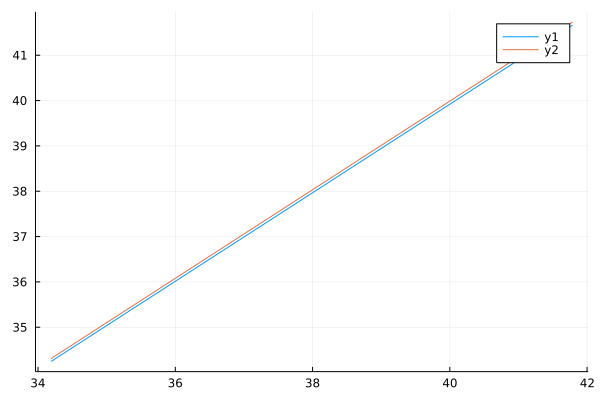

In [173]:
KP = hcat(k1,k2)
CP = hcat(c1,c2)
plot(K, KP)

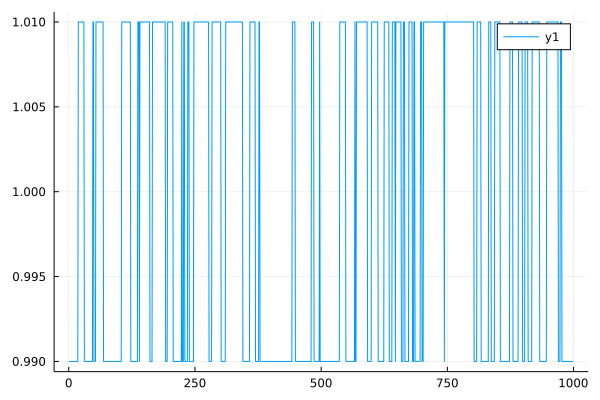

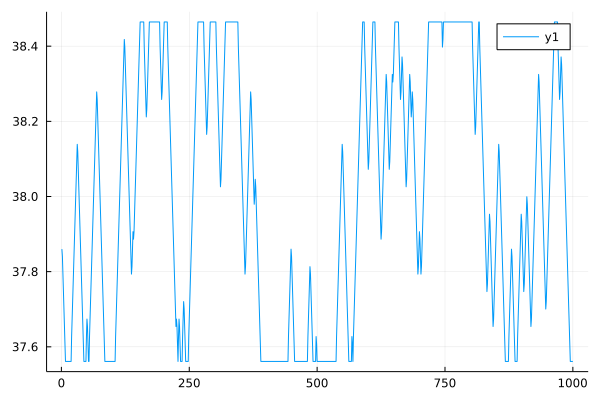

In [167]:
# Simulate
using QuantEcon
Z = [0.99 1.01]
P = Array([0.9 0.1; 0.1 0.9])
k0 = 37.85994455231658
z0 = Z[1]
T = 1000
ZIND = simulate(MarkovChain(P), T);
KIND = simulate(MarkovChain(P), T);
KPATH = k0*Array(1:T)
ZPATH = z0*Array(1:T-1);

for i in 1:T-1
    z = ZIND[i]
    KIND[i] = partialsortperm(abs.(K .- KPATH[i]), 1)
    KPATH[i+1] = KP[KIND[i], z]
    ZPATH[i] = Z[z]
    #println((z, KIND[i], KPATH[i], KPATH[i+1], ZPATH[i]))
end
display(plot(ZPATH))
display(plot(KPATH))

# 5. Coleman 1991: RBC Economy with state-dependent income tax

Problem: 
- $V(k,z) = \max_{c,k'} \{u(c)+βE[V(k',z')|z]\}$
- $u(c) = c^(1-\sigma)/(1-\sigma)$
- $c+k'= f(k,z) = zk^\alpha +(1-\delta)k$
- $c, k' \in [0, f(k,z)]$
- $E[V(k', z')|z] = \sum_{z'} P_{zz'} V(k',z')$
- $P$ is known transition matrix, $Z$ is discrete shock space, $E[z]=1$

Solution: 
- Euler: $u'(c)=\beta*E[u'(c')*f'(k')|z]$
- Find $k_{ss}$ from $1=\beta*(\alpha k_{ss}^{\alpha-1}+1-\delta)$ 
- Guess $c_{t}(k,z)$ in $[k_{ss}*0.9, k_{ss}*1.1]$x$Z$
- For each $k,z$, update $c_{t+1}(k,z)$ with $c$ that solves: $u'(c)-\beta E[u'(c_{t}(f(k,z)-c,z')) f_{1}(f(k,z)-c,z')|z]=0$ until convergence
- Store policy rules $c(k,z)$ and $k'(k,z) = f(k,z) - c(k,z)$
- From initial $k_{0},z_{0}$ simulate economy with $k_{t+1}=k'(k_{t},z_{t})$ and $c_{t}=c(k_{t},z_{t})$